11493376/11490434 [==============================] - 0s 0us/step


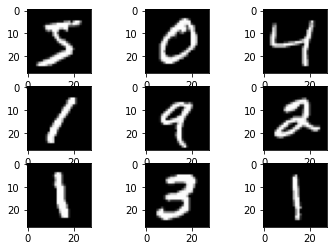

In [3]:
import tensorflow as tf
import numpy as np
import time
from keras.utils import to_categorical
from matplotlib import pyplot

# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Print first 10
pyplot.subplots(3, 3)
for i in range(9):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))

pyplot.show()

# Preprocess
num_train, num_test = x_train.shape[0], x_test.shape[0]
x_train = x_train.reshape(num_train, -1)    # vectorization
x_test = x_test.reshape(num_test, -1)

x_train = x_train.astype('float32')/255.0  # normalization to the range [0, 1] 
x_test = x_test.astype('float32')/255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# New implementation inspired by  :

https://mlfromscratch.com/neural-network-tutorial/#/

## Activation Func

In [4]:
# Activation functions 
def relu(x, derivative=False):
    if derivative:
      f = lambda x : 0 if (x <= 0) else 1
      myfunc_vec = np.vectorize(f)
      return myfunc_vec(x)
    return np.maximum(x, 0)

def sigmoid(x, derivative=False):
    if derivative:
        return (np.exp(-x))/((np.exp(-x)+1)**2)
    return 1/(1 + np.exp(-x))

def tanh(z, derivative=False):
  if derivative:
       return 1 - np.power(tanh(z), 2)
  return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

## Cross entropy (see model1_and_creativity.ipynb)



## MLP

Weight initialization and L2 implementation follows the guide:
https://cs231n.github.io/neural-networks-2/#reg

In [27]:
class MLP():
  def __init__(self, sizes, active_func=relu, epochs=10, l_rate=0.001, batch_size = 200, lambd=0.001):
    self.sizes = sizes
    self.active_func = active_func
    self.epochs = epochs
    self.layers = len(sizes) # num of hidden layers
    self.batch_size = batch_size
    self.l_rate = l_rate
    self.lambd = lambd

# Initialize the parameters
    self.params = self.initialize()

  def softmax(self, x, derivative=False):
    nx = x - x.max()
    exp_x = np.exp(nx)
    if derivative:
        return exp_x / np.sum(exp_x, axis=0) * (1 - exp_x / np.sum(exp_x, axis=0))
    return exp_x / np.sum(exp_x, axis=0)


# Initialized weights following the guide given in the assignment description
# Used small random numbers 
  def initialize(self): 
    # number of nodes in each layer
    input_layer=784
    output_layer=10

    # Case: 2 hidden layers
    if self.layers == 2 :
      hidden_1=self.sizes[0]
      hidden_2=self.sizes[1]

      params = {
        'W1':np.random.randn(hidden_1, input_layer) * 0.01,
        'W2':np.random.randn(hidden_2, hidden_1) * 0.01,
        'W3':np.random.randn(output_layer, hidden_2) * 0.01
      }
        
    # Case: 1 hidden layer
    elif self.layers == 1: 
      hidden_1=self.sizes[0]

      params = {
        'W1':np.random.randn(hidden_1, input_layer) * 0.01,
        'W3':np.random.randn(output_layer, hidden_1) * 0.01
      }

    # Case: 0 hidden layer
    else : 
          
      params = {
        'W3':np.random.randn(output_layer, input_layer) * 0.01
      }

    #  # Case: 2 hidden layers
    # if self.layers == 2 :
    #   hidden_1=self.sizes[0]
    #   hidden_2=self.sizes[1]

    #   params = {
    #     'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(2. / hidden_1),
    #     'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(2. / hidden_2),
    #     'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(2. / output_layer)
    #   }
        
    # # Case: 1 hidden layer
    # elif self.layers == 1: 
    #   hidden_1=self.sizes[0]

    #   params = {
    #     'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(2. / hidden_1),
    #     'W3':np.random.randn(output_layer, hidden_1) * np.sqrt(2. / output_layer)
    #   }

    # # Case: 0 hidden layer
    # else : 
          
    #   params = {
    #     'W3':np.random.randn(output_layer, input_layer) * np.sqrt(2. / output_layer)
    #   }

    return params

  def forward(self, x_train):
    params = self.params

    # input layer activations becomes sample
    params['A0'] = x_train

    # Case: 2 hidden layers
    if self.layers == 2 :
      # input layer to hidden layer 1
      params['Z1'] = np.dot(params["W1"], params['A0'])
      params['A1'] = self.active_func(params['Z1'])

      # hidden layer 1 to hidden layer 2
      params['Z2'] = np.dot(params["W2"], params['A1'])
      params['A2'] = self.active_func(params['Z2'])

      # hidden layer 2 to output layer
      params['Z3'] = np.dot(params["W3"], params['A2'])
      params['A3'] = self.softmax(params['Z3'])

    # Case: 1 hidden layer
    elif self.layers == 1: 
      # input layer to hidden layer 1
      params['Z1'] = np.dot(params["W1"], params['A0'])
      params['A1'] = self.active_func(params['Z1'])

      # hidden layer 1 to output layer
      params['Z3'] = np.dot(params["W3"], params['A1'])
      params['A3'] = self.softmax(params['Z3'])

    # Case: 0 hidden layer
    else : 
      # input layer to hidden layer 1
      params['Z3'] = np.dot(params["W3"], params['A0'])
      params['A3'] = self.softmax(params['Z3'])

    return params['A3']

  def backward_propagation(self, y_train, output):
    params = self.params
    cache = {} # stores values calculated from 

    # Case: 2 hidden layers
    if self.layers == 2 :
      # Calculate W3 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
      cache['W3'] = np.outer(error, params['A2'])

      # Calculate W2 update
      error = np.dot(params['W3'].T, error) * self.active_func(params['Z2'], derivative=True)
      cache['W2'] = np.outer(error, params['A1'])

      # Calculate W1 update
      error = np.dot(params['W2'].T, error) * self.active_func(params['Z1'], derivative=True)
      cache['W1'] = np.outer(error, params['A0'])

    # Case: 1 hidden layer
    elif self.layers == 1 :
      # Calculate W3 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
      cache['W3'] = np.outer(error, params['A1'])

      # Calculate W1 update
      error = np.dot(params['W3'].T, error) * self.active_func(params['Z1'], derivative=True)
      cache['W1'] = np.outer(error, params['A0'])

    # Case: 0 hidden layer
    else : 
      # Calculate W3 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
      cache['W3'] = np.outer(error, params['A0'])

    return cache

  #################### Backward propagation with L2 regularization #######################
  def backward_propagation_w_l2(self, y_train, output):
    params = self.params
    cache = {} # stores calculated back propagation errors
    m = x_train.shape[1]

    # Case: 2 hidden layers
    if self.layers == 2 :
      # Calculate W3 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
      cache['W3'] = np.outer(error, params['A2']) + (self.lambd*params['W3'])

      # Calculate W2 update
      error = np.dot(params['W3'].T, error) * self.active_func(params['Z2'], derivative=True)
      cache['W2'] = np.outer(error, params['A1']) + (self.lambd*params['W2'])

      # Calculate W1 update
      error = np.dot(params['W2'].T, error) * self.active_func(params['Z1'], derivative=True) 
      cache['W1'] = np.outer(error, params['A0']) + (self.lambd*params['W1'])

    # Case: 1 hidden layer
    elif self.layers == 1 :
      # Calculate W3 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True) 
      cache['W3'] = np.outer(error, params['A1']) + (self.lambd*params['W3'])

      # Calculate W1 update
      error = np.dot(params['W3'].T, error) * self.active_func(params['Z1'], derivative=True) 
      cache['W1'] = np.outer(error, params['A0']) + (self.lambd*params['W1'])

    # Case: 0 hidden layer
    else : 
      # Calculate W3 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True) 
      cache['W3'] = np.outer(error, params['A0']) + (self.lambd*params['W3'])

    return cache

  def update_weights(self, values):
    # Update weights using Stochastic Gradient Descent
    for k, v in values.items():
        self.params[k] -= self.l_rate * v

  def predict(self, x_test, y_test):
    yh = []
    for x, y in zip(x_test, y_test):
        output = self.forward(x)
        pred = np.argmax(output)
        yh.append(pred)
    return yh

  def fit(self, x_train, y_train):
    start_time = time.time()
    for iteration in range(self.epochs):
        for x,y in zip(x_train, y_train):
            output = self.forward(x)
            values = self.backward_propagation(y, output)
            self.update_weights(values)

 ## Utility function created to facilitate the comparison of accuracies by epochs
  def fit_predict_by_epoch(self, x_train, y_train, x_test, y_test, l2=False):
    start_time = time.time()
    test_acc = []
    train_acc = []
    loss = []
    for iteration in range(self.epochs):
        for x,y in zip(x_train, y_train):
            output = self.forward(x)
            if l2:
              values = self.backward_propagation_w_l2(y, output)
            else:
              values = self.backward_propagation(y, output)
            self.update_weights(values)
        
        yh = self.predict(x_train, y_train)
        # l = compute_loss(y, yh)
        accuracy_train = evaluate_acc(yh, y_train)

        yh2 = self.predict(x_test, y_test)
        accuracy_test = evaluate_acc(yh2, y_test)

        print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.3f}%, Test Accuracy: {3:.3f}%'.format(
            iteration+1, time.time() - start_time, evaluate_acc(yh, y_train) * 100, accuracy_test *100
        ))

        # loss.append(l)
        test_acc.append(accuracy_test)
        train_acc.append(accuracy_train)

    return yh, yh2, train_acc, test_acc

## Evaluation metrics

In [7]:
# evaluate accuracy
def evaluate_acc(y_pred, y_test):
  y = y_test.argmax(1) # change back from one hot coding
  return sum(y_pred == y) / len(y)

In [8]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
# 20N
def plotByClass(y_pred, y_test):
  bins = np.linspace(0, 10, 11,dtype=int)
  fig, ax = plt.subplots()
  ax.set_xticks(bins + 0.5)
  ax.set_xticklabels(bins,rotation=90, horizontalalignment='center')
  _ = ax.hist([y_pred, y_test], bins, label=['y_pred', 'test_labels'])
  pyplot.legend(loc='upper right')
  pyplot.title('Prediction Counts by Class on MNIST', fontdict=None, loc='center', pad=None)

## Run Experiments

In [9]:
from matplotlib import pyplot as plt
# Plot accuracies vs epochs to inspect trend
def epochPlot(epochs, train_acc, test_acc, title):
      plt.plot(range(epochs), test_acc, '-', label='test', color='g')
      plt.plot(range(epochs), train_acc, '-', label='train', color='r')
      plt.legend()
      plt.xlabel('Number of epochs')
      plt.ylabel('Accuracy')
      plt.title(title, loc='center', pad=None)
      plt.show()  

### Relu

Epoch: 1, Time Spent: 6.53s, Train Accuracy: 20.527%, Test Accuracy: 20.340%
Epoch: 2, Time Spent: 13.09s, Train Accuracy: 29.662%, Test Accuracy: 29.700%
Epoch: 3, Time Spent: 19.68s, Train Accuracy: 36.878%, Test Accuracy: 37.170%
Epoch: 4, Time Spent: 26.23s, Train Accuracy: 43.173%, Test Accuracy: 43.950%
Epoch: 5, Time Spent: 32.72s, Train Accuracy: 49.137%, Test Accuracy: 49.920%
Epoch: 6, Time Spent: 39.22s, Train Accuracy: 53.925%, Test Accuracy: 54.730%
Epoch: 7, Time Spent: 45.78s, Train Accuracy: 57.650%, Test Accuracy: 58.690%
Epoch: 8, Time Spent: 52.26s, Train Accuracy: 60.618%, Test Accuracy: 61.890%
Epoch: 9, Time Spent: 58.78s, Train Accuracy: 63.023%, Test Accuracy: 64.360%
Epoch: 10, Time Spent: 65.30s, Train Accuracy: 65.030%, Test Accuracy: 66.350%


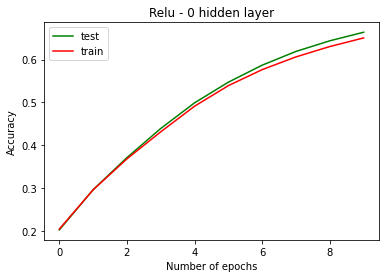

In [31]:
mlp = MLP(sizes=[], active_func=relu, epochs=10, l_rate=0.001)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Relu - 0 hidden layer")

Epoch: 1, Time Spent: 6.32s, Train Accuracy: 87.670%, Test Accuracy: 88.380%
Epoch: 2, Time Spent: 12.79s, Train Accuracy: 89.192%, Test Accuracy: 89.820%
Epoch: 3, Time Spent: 19.27s, Train Accuracy: 89.848%, Test Accuracy: 90.570%
Epoch: 4, Time Spent: 25.77s, Train Accuracy: 90.302%, Test Accuracy: 90.830%
Epoch: 5, Time Spent: 32.22s, Train Accuracy: 90.605%, Test Accuracy: 91.060%
Epoch: 6, Time Spent: 38.70s, Train Accuracy: 90.810%, Test Accuracy: 91.190%
Epoch: 7, Time Spent: 45.17s, Train Accuracy: 90.988%, Test Accuracy: 91.280%
Epoch: 8, Time Spent: 51.66s, Train Accuracy: 91.140%, Test Accuracy: 91.470%
Epoch: 9, Time Spent: 58.16s, Train Accuracy: 91.265%, Test Accuracy: 91.520%
Epoch: 10, Time Spent: 64.64s, Train Accuracy: 91.352%, Test Accuracy: 91.520%


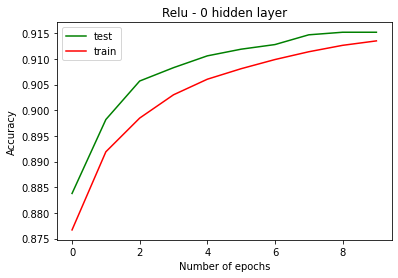

In [14]:
mlp = MLP(sizes=[], active_func=relu, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Relu - 0 hidden layer")

Epoch: 1, Time Spent: 6.90s, Train Accuracy: 75.773%, Test Accuracy: 76.470%
Epoch: 2, Time Spent: 13.89s, Train Accuracy: 82.863%, Test Accuracy: 83.700%
Epoch: 3, Time Spent: 20.90s, Train Accuracy: 85.170%, Test Accuracy: 86.060%
Epoch: 4, Time Spent: 27.97s, Train Accuracy: 86.472%, Test Accuracy: 87.450%
Epoch: 5, Time Spent: 34.90s, Train Accuracy: 87.340%, Test Accuracy: 88.370%
Epoch: 6, Time Spent: 41.87s, Train Accuracy: 87.975%, Test Accuracy: 88.930%
Epoch: 7, Time Spent: 49.11s, Train Accuracy: 88.478%, Test Accuracy: 89.350%
Epoch: 8, Time Spent: 56.14s, Train Accuracy: 88.878%, Test Accuracy: 89.590%
Epoch: 9, Time Spent: 63.12s, Train Accuracy: 89.237%, Test Accuracy: 89.940%
Epoch: 10, Time Spent: 70.10s, Train Accuracy: 89.508%, Test Accuracy: 90.120%


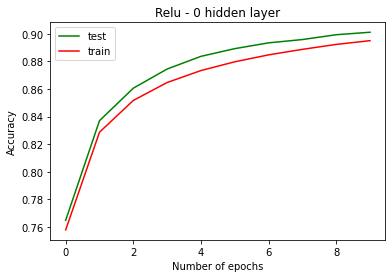

In [122]:
mlp = MLP(sizes=[], active_func=relu, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Relu - 0 hidden layer")

Epoch: 1, Time Spent: 57.24s, Train Accuracy: 62.465%, Test Accuracy: 63.670%
Epoch: 2, Time Spent: 114.56s, Train Accuracy: 78.242%, Test Accuracy: 79.170%
Epoch: 3, Time Spent: 171.72s, Train Accuracy: 82.397%, Test Accuracy: 83.190%
Epoch: 4, Time Spent: 229.14s, Train Accuracy: 84.453%, Test Accuracy: 85.000%
Epoch: 5, Time Spent: 286.07s, Train Accuracy: 85.763%, Test Accuracy: 86.350%
Epoch: 6, Time Spent: 343.12s, Train Accuracy: 86.703%, Test Accuracy: 87.220%
Epoch: 7, Time Spent: 400.33s, Train Accuracy: 87.420%, Test Accuracy: 87.930%
Epoch: 8, Time Spent: 457.43s, Train Accuracy: 88.025%, Test Accuracy: 88.360%
Epoch: 9, Time Spent: 514.21s, Train Accuracy: 88.442%, Test Accuracy: 88.780%
Epoch: 10, Time Spent: 571.33s, Train Accuracy: 88.768%, Test Accuracy: 89.070%


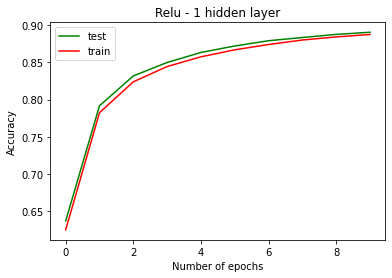

In [30]:
mlp = MLP(sizes=[128], active_func=relu, epochs=10, l_rate=0.001)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Relu - 1 hidden layer")

Epoch: 1, Time Spent: 55.49s, Train Accuracy: 77.613%, Test Accuracy: 78.300%
Epoch: 2, Time Spent: 110.59s, Train Accuracy: 87.688%, Test Accuracy: 88.180%
Epoch: 3, Time Spent: 165.47s, Train Accuracy: 89.323%, Test Accuracy: 89.750%
Epoch: 4, Time Spent: 220.99s, Train Accuracy: 90.245%, Test Accuracy: 90.580%
Epoch: 5, Time Spent: 276.26s, Train Accuracy: 90.883%, Test Accuracy: 91.230%
Epoch: 6, Time Spent: 331.55s, Train Accuracy: 91.507%, Test Accuracy: 91.690%
Epoch: 7, Time Spent: 386.43s, Train Accuracy: 92.007%, Test Accuracy: 92.150%
Epoch: 8, Time Spent: 441.42s, Train Accuracy: 92.498%, Test Accuracy: 92.560%
Epoch: 9, Time Spent: 496.60s, Train Accuracy: 92.978%, Test Accuracy: 92.940%
Epoch: 10, Time Spent: 551.80s, Train Accuracy: 93.378%, Test Accuracy: 93.260%


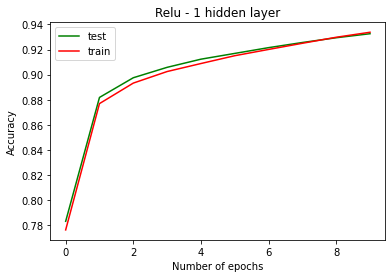

In [16]:
mlp = MLP(sizes=[128], active_func=relu, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Relu - 1 hidden layer")

Epoch: 1, Time Spent: 60.95s, Train Accuracy: 90.895%, Test Accuracy: 91.260%
Epoch: 2, Time Spent: 121.53s, Train Accuracy: 92.768%, Test Accuracy: 92.710%
Epoch: 3, Time Spent: 182.08s, Train Accuracy: 93.768%, Test Accuracy: 93.530%
Epoch: 4, Time Spent: 242.96s, Train Accuracy: 94.420%, Test Accuracy: 94.200%
Epoch: 5, Time Spent: 303.27s, Train Accuracy: 94.930%, Test Accuracy: 94.440%
Epoch: 6, Time Spent: 364.02s, Train Accuracy: 95.342%, Test Accuracy: 94.690%
Epoch: 7, Time Spent: 424.77s, Train Accuracy: 95.673%, Test Accuracy: 94.910%
Epoch: 8, Time Spent: 486.00s, Train Accuracy: 95.962%, Test Accuracy: 95.090%
Epoch: 9, Time Spent: 546.93s, Train Accuracy: 96.158%, Test Accuracy: 95.320%
Epoch: 10, Time Spent: 607.79s, Train Accuracy: 96.333%, Test Accuracy: 95.520%


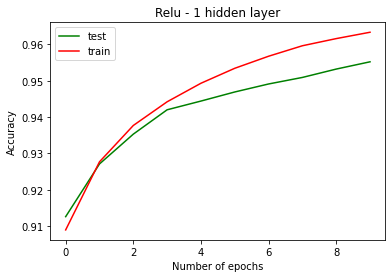

In [142]:
mlp = MLP(sizes=[128], active_func=relu, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Relu - 1 hidden layer")

Epoch: 1, Time Spent: 75.77s, Train Accuracy: 91.678%, Test Accuracy: 92.020%
Epoch: 2, Time Spent: 151.47s, Train Accuracy: 93.743%, Test Accuracy: 93.620%
Epoch: 3, Time Spent: 227.20s, Train Accuracy: 94.828%, Test Accuracy: 94.330%
Epoch: 4, Time Spent: 303.18s, Train Accuracy: 95.595%, Test Accuracy: 94.940%
Epoch: 5, Time Spent: 378.41s, Train Accuracy: 96.115%, Test Accuracy: 95.280%
Epoch: 6, Time Spent: 454.77s, Train Accuracy: 96.505%, Test Accuracy: 95.720%
Epoch: 7, Time Spent: 530.36s, Train Accuracy: 96.798%, Test Accuracy: 95.960%
Epoch: 8, Time Spent: 606.42s, Train Accuracy: 97.047%, Test Accuracy: 96.240%
Epoch: 9, Time Spent: 682.13s, Train Accuracy: 97.235%, Test Accuracy: 96.430%
Epoch: 10, Time Spent: 757.78s, Train Accuracy: 97.430%, Test Accuracy: 96.510%


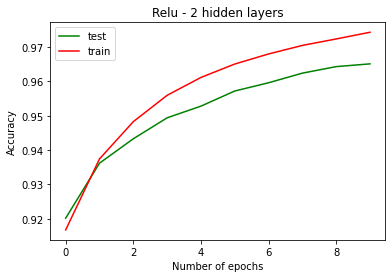

In [124]:
mlp = MLP(sizes=[128, 128], active_func=relu, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Relu - 2 hidden layers")

### Relu with L2

Epoch: 1, Time Spent: 93.35s, Train Accuracy: 85.300%, Test Accuracy: 85.620%
Epoch: 2, Time Spent: 186.52s, Train Accuracy: 84.532%, Test Accuracy: 84.760%
Epoch: 3, Time Spent: 281.17s, Train Accuracy: 84.318%, Test Accuracy: 84.690%
Epoch: 4, Time Spent: 375.27s, Train Accuracy: 84.978%, Test Accuracy: 85.510%
Epoch: 5, Time Spent: 469.73s, Train Accuracy: 85.065%, Test Accuracy: 85.660%
Epoch: 6, Time Spent: 563.67s, Train Accuracy: 84.735%, Test Accuracy: 85.360%
Epoch: 7, Time Spent: 655.71s, Train Accuracy: 85.185%, Test Accuracy: 85.820%
Epoch: 8, Time Spent: 749.20s, Train Accuracy: 85.113%, Test Accuracy: 85.810%
Epoch: 9, Time Spent: 845.94s, Train Accuracy: 85.290%, Test Accuracy: 85.990%
Epoch: 10, Time Spent: 943.64s, Train Accuracy: 85.292%, Test Accuracy: 86.090%


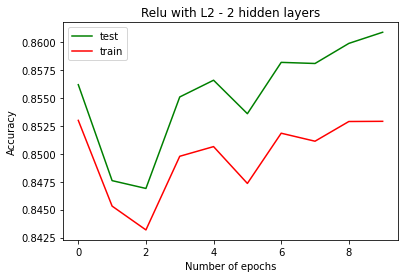

In [141]:
mlp = MLP(sizes=[128, 128], active_func=relu, epochs=10, l_rate=0.01, lambd=0.001)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test, l2=True)
epochPlot(10,train_acc,test_acc, "Relu with L2 - 2 hidden layers")

### Relu with unnormalized data

In [163]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess
num_train, num_test = x_train.shape[0], x_test.shape[0]
x_train = x_train.reshape(num_train, -1)    # vectorization
x_test = x_test.reshape(num_test, -1)

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [164]:
# evaluate accuracy
def evaluate_acc(y_pred, y_test):
  y = y_test
  return sum(y_pred == y) / len(y)

Epoch: 1, Time Spent: 77.32s, Train Accuracy: 10.442%, Test Accuracy: 10.280%
Epoch: 2, Time Spent: 152.63s, Train Accuracy: 10.442%, Test Accuracy: 10.280%
Epoch: 3, Time Spent: 226.54s, Train Accuracy: 10.442%, Test Accuracy: 10.280%
Epoch: 4, Time Spent: 301.44s, Train Accuracy: 10.442%, Test Accuracy: 10.280%
Epoch: 5, Time Spent: 379.17s, Train Accuracy: 10.442%, Test Accuracy: 10.280%
Epoch: 6, Time Spent: 455.57s, Train Accuracy: 10.442%, Test Accuracy: 10.280%
Epoch: 7, Time Spent: 531.35s, Train Accuracy: 10.442%, Test Accuracy: 10.280%
Epoch: 8, Time Spent: 607.98s, Train Accuracy: 10.442%, Test Accuracy: 10.280%
Epoch: 9, Time Spent: 682.60s, Train Accuracy: 10.442%, Test Accuracy: 10.280%
Epoch: 10, Time Spent: 756.86s, Train Accuracy: 10.442%, Test Accuracy: 10.280%


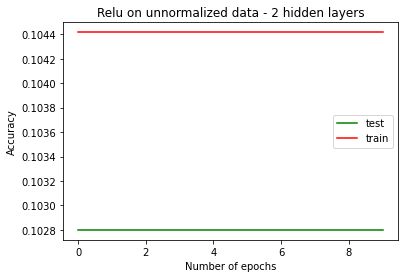

In [168]:
mlp = MLP(sizes=[128, 128], active_func=relu, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Relu on unnormalized data - 2 hidden layers")

### Tanh

Make sure to run Run normalization (cell 1) or the 2 lines below

Epoch: 1, Time Spent: 65.33s, Train Accuracy: 51.517%, Test Accuracy: 52.760%
Epoch: 2, Time Spent: 132.69s, Train Accuracy: 58.572%, Test Accuracy: 58.610%
Epoch: 3, Time Spent: 199.66s, Train Accuracy: 84.000%, Test Accuracy: 84.390%
Epoch: 4, Time Spent: 266.89s, Train Accuracy: 87.187%, Test Accuracy: 87.350%
Epoch: 5, Time Spent: 333.73s, Train Accuracy: 89.062%, Test Accuracy: 89.260%
Epoch: 6, Time Spent: 401.21s, Train Accuracy: 90.400%, Test Accuracy: 90.340%
Epoch: 7, Time Spent: 468.33s, Train Accuracy: 91.448%, Test Accuracy: 91.360%
Epoch: 8, Time Spent: 536.08s, Train Accuracy: 92.265%, Test Accuracy: 92.240%
Epoch: 9, Time Spent: 603.46s, Train Accuracy: 93.023%, Test Accuracy: 93.010%
Epoch: 10, Time Spent: 670.91s, Train Accuracy: 93.613%, Test Accuracy: 93.590%


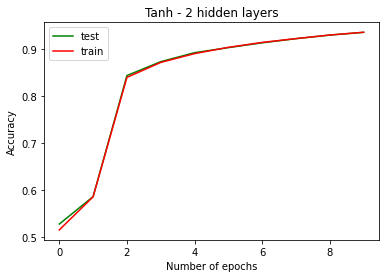

In [13]:
mlp = MLP(sizes=[128, 128], active_func=tanh, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Tanh - 2 hidden layers")

In [ ]:
x_train = x_train.astype('float32')/255.0  # normalization to the range [0, 1] 
x_test = x_test.astype('float32')/255.0

Epoch: 1, Time Spent: 72.45s, Train Accuracy: 91.280%, Test Accuracy: 91.460%
Epoch: 2, Time Spent: 144.97s, Train Accuracy: 93.248%, Test Accuracy: 93.100%
Epoch: 3, Time Spent: 216.88s, Train Accuracy: 94.332%, Test Accuracy: 93.960%
Epoch: 4, Time Spent: 288.70s, Train Accuracy: 95.137%, Test Accuracy: 94.500%
Epoch: 5, Time Spent: 360.46s, Train Accuracy: 95.712%, Test Accuracy: 94.960%
Epoch: 6, Time Spent: 432.69s, Train Accuracy: 96.127%, Test Accuracy: 95.380%
Epoch: 7, Time Spent: 505.19s, Train Accuracy: 96.420%, Test Accuracy: 95.620%
Epoch: 8, Time Spent: 577.15s, Train Accuracy: 96.718%, Test Accuracy: 95.830%
Epoch: 9, Time Spent: 649.37s, Train Accuracy: 97.008%, Test Accuracy: 96.060%
Epoch: 10, Time Spent: 722.65s, Train Accuracy: 97.183%, Test Accuracy: 96.180%


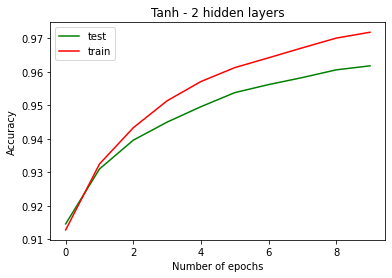

In [143]:
mlp = MLP(sizes=[128, 128], active_func=tanh, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Tanh - 2 hidden layers")

### Sigmoid

Epoch: 1, Time Spent: 60.56s, Train Accuracy: 73.440%, Test Accuracy: 73.950%
Epoch: 2, Time Spent: 120.76s, Train Accuracy: 77.428%, Test Accuracy: 77.890%
Epoch: 3, Time Spent: 180.71s, Train Accuracy: 80.150%, Test Accuracy: 80.430%
Epoch: 4, Time Spent: 240.10s, Train Accuracy: 81.230%, Test Accuracy: 81.610%
Epoch: 5, Time Spent: 300.15s, Train Accuracy: 88.408%, Test Accuracy: 88.700%
Epoch: 6, Time Spent: 359.85s, Train Accuracy: 89.458%, Test Accuracy: 89.640%
Epoch: 7, Time Spent: 418.37s, Train Accuracy: 90.140%, Test Accuracy: 90.330%
Epoch: 8, Time Spent: 477.51s, Train Accuracy: 90.638%, Test Accuracy: 90.880%
Epoch: 9, Time Spent: 536.64s, Train Accuracy: 91.020%, Test Accuracy: 91.170%
Epoch: 10, Time Spent: 595.18s, Train Accuracy: 91.330%, Test Accuracy: 91.460%


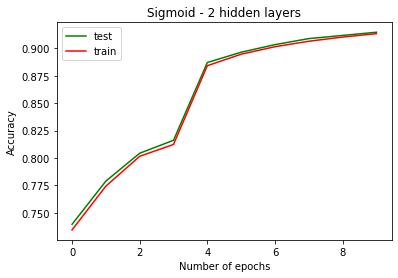

In [34]:
mlp = MLP(sizes=[128, 128], active_func=sigmoid, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Sigmoid - 2 hidden layers")

Epoch: 1, Time Spent: 65.21s, Train Accuracy: 63.547%, Test Accuracy: 63.510%
Epoch: 2, Time Spent: 130.36s, Train Accuracy: 63.837%, Test Accuracy: 64.370%
Epoch: 3, Time Spent: 195.61s, Train Accuracy: 68.003%, Test Accuracy: 69.100%
Epoch: 4, Time Spent: 261.79s, Train Accuracy: 72.415%, Test Accuracy: 73.500%
Epoch: 5, Time Spent: 328.31s, Train Accuracy: 71.465%, Test Accuracy: 72.260%
Epoch: 6, Time Spent: 397.45s, Train Accuracy: 72.512%, Test Accuracy: 73.140%
Epoch: 7, Time Spent: 463.31s, Train Accuracy: 74.055%, Test Accuracy: 74.820%
Epoch: 8, Time Spent: 530.32s, Train Accuracy: 75.635%, Test Accuracy: 76.370%
Epoch: 9, Time Spent: 596.53s, Train Accuracy: 76.953%, Test Accuracy: 77.680%
Epoch: 10, Time Spent: 662.93s, Train Accuracy: 84.485%, Test Accuracy: 85.280%


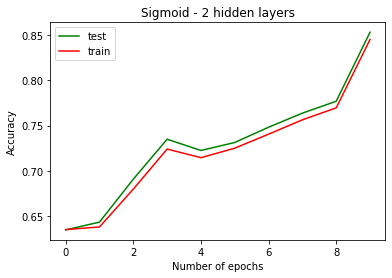

In [144]:
mlp = MLP(sizes=[128, 128], active_func=sigmoid, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Sigmoid - 2 hidden layers")

## Creativity

### Relu - [512 512] nodes

Epoch: 1, Time Spent: 355.49s, Train Accuracy: 94.757%, Test Accuracy: 94.450%
Epoch: 2, Time Spent: 712.18s, Train Accuracy: 96.400%, Test Accuracy: 95.630%
Epoch: 3, Time Spent: 1066.92s, Train Accuracy: 97.185%, Test Accuracy: 96.250%
Epoch: 4, Time Spent: 1422.87s, Train Accuracy: 97.633%, Test Accuracy: 96.610%
Epoch: 5, Time Spent: 1770.30s, Train Accuracy: 97.923%, Test Accuracy: 96.840%
Epoch: 6, Time Spent: 2120.80s, Train Accuracy: 98.212%, Test Accuracy: 96.970%
Epoch: 7, Time Spent: 2475.92s, Train Accuracy: 98.328%, Test Accuracy: 96.980%
Epoch: 8, Time Spent: 2828.71s, Train Accuracy: 98.357%, Test Accuracy: 96.890%
Epoch: 9, Time Spent: 3174.65s, Train Accuracy: 98.237%, Test Accuracy: 96.710%
Epoch: 10, Time Spent: 3520.43s, Train Accuracy: 98.358%, Test Accuracy: 96.890%


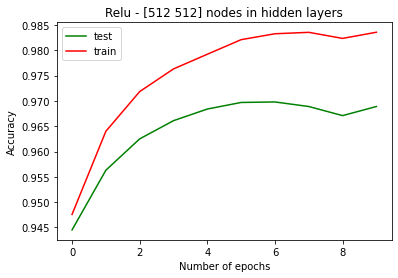

In [11]:
mlp = MLP(sizes=[512, 512], active_func=relu, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Relu - [512 512] nodes in hidden layers")

### Relu - [256 256] nodes

Epoch: 1, Time Spent: 150.61s, Train Accuracy: 93.405%, Test Accuracy: 93.240%
Epoch: 2, Time Spent: 283.29s, Train Accuracy: 95.282%, Test Accuracy: 94.760%
Epoch: 3, Time Spent: 427.55s, Train Accuracy: 96.155%, Test Accuracy: 95.460%
Epoch: 4, Time Spent: 567.15s, Train Accuracy: 96.725%, Test Accuracy: 95.920%
Epoch: 5, Time Spent: 706.18s, Train Accuracy: 97.068%, Test Accuracy: 96.300%
Epoch: 6, Time Spent: 845.12s, Train Accuracy: 97.308%, Test Accuracy: 96.400%
Epoch: 7, Time Spent: 976.36s, Train Accuracy: 97.488%, Test Accuracy: 96.470%
Epoch: 8, Time Spent: 1110.86s, Train Accuracy: 97.643%, Test Accuracy: 96.580%
Epoch: 9, Time Spent: 1239.89s, Train Accuracy: 97.762%, Test Accuracy: 96.630%
Epoch: 10, Time Spent: 1371.26s, Train Accuracy: 97.872%, Test Accuracy: 96.710%


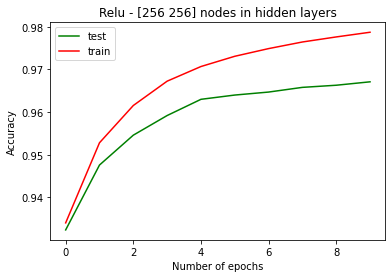

In [10]:
mlp = MLP(sizes=[256, 256], active_func=relu, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Relu - [256 256] nodes in hidden layers")

### Relu - [128 64] nodes

Epoch: 1, Time Spent: 70.93s, Train Accuracy: 90.878%, Test Accuracy: 91.060%
Epoch: 2, Time Spent: 140.40s, Train Accuracy: 93.138%, Test Accuracy: 93.140%
Epoch: 3, Time Spent: 210.12s, Train Accuracy: 94.348%, Test Accuracy: 93.950%
Epoch: 4, Time Spent: 280.57s, Train Accuracy: 95.075%, Test Accuracy: 94.480%
Epoch: 5, Time Spent: 350.62s, Train Accuracy: 95.582%, Test Accuracy: 94.790%
Epoch: 6, Time Spent: 420.34s, Train Accuracy: 95.988%, Test Accuracy: 95.050%
Epoch: 7, Time Spent: 489.79s, Train Accuracy: 96.323%, Test Accuracy: 95.240%
Epoch: 8, Time Spent: 559.27s, Train Accuracy: 96.637%, Test Accuracy: 95.450%
Epoch: 9, Time Spent: 628.78s, Train Accuracy: 96.847%, Test Accuracy: 95.750%
Epoch: 10, Time Spent: 698.47s, Train Accuracy: 97.075%, Test Accuracy: 95.910%


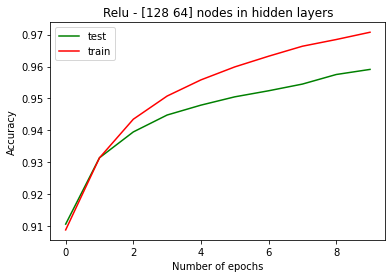

In [145]:
mlp = MLP(sizes=[128, 64], active_func=relu, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Relu - [128 64] nodes in hidden layers")

### Relu - [64 64] nodes

Epoch: 1, Time Spent: 46.25s, Train Accuracy: 88.718%, Test Accuracy: 89.140%
Epoch: 2, Time Spent: 92.68s, Train Accuracy: 91.817%, Test Accuracy: 91.740%
Epoch: 3, Time Spent: 139.40s, Train Accuracy: 93.125%, Test Accuracy: 92.980%
Epoch: 4, Time Spent: 186.07s, Train Accuracy: 93.957%, Test Accuracy: 93.730%
Epoch: 5, Time Spent: 232.73s, Train Accuracy: 94.622%, Test Accuracy: 94.270%
Epoch: 6, Time Spent: 279.68s, Train Accuracy: 95.112%, Test Accuracy: 94.640%
Epoch: 7, Time Spent: 326.36s, Train Accuracy: 95.518%, Test Accuracy: 94.910%
Epoch: 8, Time Spent: 372.92s, Train Accuracy: 95.808%, Test Accuracy: 95.170%
Epoch: 9, Time Spent: 419.76s, Train Accuracy: 96.083%, Test Accuracy: 95.270%
Epoch: 10, Time Spent: 466.28s, Train Accuracy: 96.352%, Test Accuracy: 95.470%


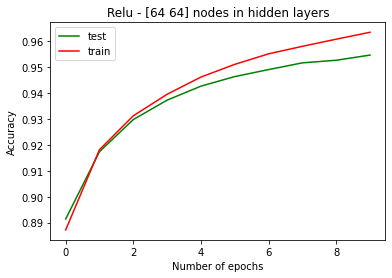

In [146]:
mlp = MLP(sizes=[64, 64], active_func=relu, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Relu - [64 64] nodes in hidden layers")

### Relu - [32 32] nodes

Epoch: 1, Time Spent: 30.33s, Train Accuracy: 84.497%, Test Accuracy: 85.630%
Epoch: 2, Time Spent: 63.52s, Train Accuracy: 88.730%, Test Accuracy: 89.050%
Epoch: 3, Time Spent: 95.64s, Train Accuracy: 90.377%, Test Accuracy: 90.340%
Epoch: 4, Time Spent: 125.65s, Train Accuracy: 91.425%, Test Accuracy: 91.120%
Epoch: 5, Time Spent: 155.72s, Train Accuracy: 92.130%, Test Accuracy: 91.700%
Epoch: 6, Time Spent: 185.65s, Train Accuracy: 92.622%, Test Accuracy: 92.110%
Epoch: 7, Time Spent: 215.20s, Train Accuracy: 92.960%, Test Accuracy: 92.590%
Epoch: 8, Time Spent: 245.06s, Train Accuracy: 93.113%, Test Accuracy: 92.980%
Epoch: 9, Time Spent: 274.94s, Train Accuracy: 10.218%, Test Accuracy: 10.100%
Epoch: 10, Time Spent: 304.70s, Train Accuracy: 9.863%, Test Accuracy: 9.580%


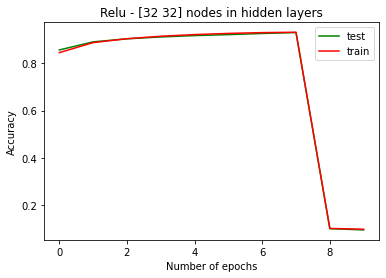

In [148]:
mlp = MLP(sizes=[32, 32], active_func=relu, epochs=10, l_rate=0.01)
yh, yh2, train_acc, test_acc = mlp.fit_predict_by_epoch(x_train, y_train, x_test, y_test)
epochPlot(10,train_acc,test_acc, "Relu - [32 32] nodes in hidden layers")

[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 3, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 7, 9, 7, 9, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 1, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 4, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 9, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 3, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 3, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 7, 7, 9, 2, 2, 4, 1, 5, 3, 8, 7, 2, 3, 0, 2, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 0, 8, 5, 7, 7, 3, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 2, 5, 9, 2, 6, 4, 1, 5, 4, 2, 9, 2, 0, 4, 0, 0, 2, 8, 6, 7, 1, 2, 4, 0, 2, 9, 4, 3, 3, 0, 0, 5, 1, 9, 6, 5, 3, 5, 1, 3, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 

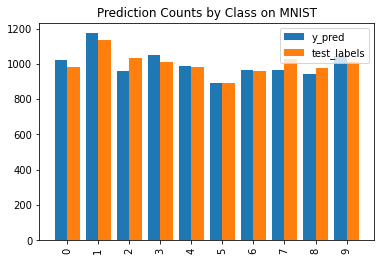

In [69]:
# Plot by class
print(yh_tanh)
print(y_labels.tolist())

plotByClass(yh_tanh, y_labels)

In [27]:
mlp = MLP(sizes=[128, 128], active_func=relu, epochs=10, l_rate=0.001)
mlp.train(x_train, y_train, x_test, y_test)

Epoch: 1, Time Spent: 67.93s, Accuracy: 80.60%
Epoch: 2, Time Spent: 135.89s, Accuracy: 86.53%
Epoch: 3, Time Spent: 204.02s, Accuracy: 88.51%
Epoch: 4, Time Spent: 272.16s, Accuracy: 89.45%
Epoch: 5, Time Spent: 340.10s, Accuracy: 90.12%
Epoch: 6, Time Spent: 408.01s, Accuracy: 90.57%
Epoch: 7, Time Spent: 475.98s, Accuracy: 91.06%
Epoch: 8, Time Spent: 543.95s, Accuracy: 91.39%
Epoch: 9, Time Spent: 611.95s, Accuracy: 91.73%
Epoch: 10, Time Spent: 679.93s, Accuracy: 91.90%


In [72]:
mlp = MLP(sizes=[], active_func=relu, epochs=10, l_rate=0.01)
yh_relu0 = mlp.train(x_train, y_train, x_test, y_test)

Epoch: 1, Time Spent: 4.96s, Accuracy: 76.56%
Epoch: 2, Time Spent: 9.96s, Accuracy: 83.85%
Epoch: 3, Time Spent: 14.94s, Accuracy: 86.02%
Epoch: 4, Time Spent: 19.90s, Accuracy: 87.36%
Epoch: 5, Time Spent: 24.94s, Accuracy: 87.96%
Epoch: 6, Time Spent: 29.81s, Accuracy: 88.64%
Epoch: 7, Time Spent: 34.84s, Accuracy: 89.12%
Epoch: 8, Time Spent: 39.72s, Accuracy: 89.53%
Epoch: 9, Time Spent: 44.65s, Accuracy: 89.84%
Epoch: 10, Time Spent: 49.42s, Accuracy: 90.01%
Epoch: 11, Time Spent: 54.29s, Accuracy: 90.15%
Epoch: 12, Time Spent: 59.13s, Accuracy: 90.27%
Epoch: 13, Time Spent: 64.06s, Accuracy: 90.34%
Epoch: 14, Time Spent: 68.98s, Accuracy: 90.49%
Epoch: 15, Time Spent: 73.88s, Accuracy: 90.60%
Epoch: 16, Time Spent: 78.76s, Accuracy: 90.76%
Epoch: 17, Time Spent: 83.58s, Accuracy: 90.87%
Epoch: 18, Time Spent: 88.55s, Accuracy: 90.97%
Epoch: 19, Time Spent: 93.42s, Accuracy: 91.12%
Epoch: 20, Time Spent: 98.31s, Accuracy: 91.16%
Epoch: 21, Time Spent: 103.20s, Accuracy: 91.21%
Ep

In [ ]:
# Plot by class
plotByClass(yh_relu0, y_labels)

In [75]:
mlp = MLP(sizes=[128], active_func=relu, epochs=10, l_rate=0.01)
yh_relu1 = mlp.train(x_train, y_train, x_test, y_test)

Epoch: 1, Time Spent: 55.62s, Accuracy: 91.31%
Epoch: 2, Time Spent: 110.96s, Accuracy: 93.03%
Epoch: 3, Time Spent: 166.48s, Accuracy: 93.97%
Epoch: 4, Time Spent: 221.90s, Accuracy: 94.46%
Epoch: 5, Time Spent: 277.43s, Accuracy: 94.83%
Epoch: 6, Time Spent: 332.94s, Accuracy: 94.94%
Epoch: 7, Time Spent: 388.52s, Accuracy: 95.30%
Epoch: 8, Time Spent: 443.92s, Accuracy: 95.57%
Epoch: 9, Time Spent: 499.36s, Accuracy: 95.67%
Epoch: 10, Time Spent: 554.71s, Accuracy: 95.81%
Epoch: 11, Time Spent: 610.06s, Accuracy: 95.91%
Epoch: 12, Time Spent: 665.39s, Accuracy: 96.08%
Epoch: 13, Time Spent: 720.90s, Accuracy: 96.18%
Epoch: 14, Time Spent: 776.36s, Accuracy: 96.22%
Epoch: 15, Time Spent: 831.66s, Accuracy: 96.27%
Epoch: 16, Time Spent: 887.07s, Accuracy: 96.34%
Epoch: 17, Time Spent: 942.41s, Accuracy: 96.38%
Epoch: 18, Time Spent: 997.86s, Accuracy: 96.43%
Epoch: 19, Time Spent: 1053.20s, Accuracy: 96.42%
Epoch: 20, Time Spent: 1108.61s, Accuracy: 96.45%
Epoch: 21, Time Spent: 1163.

In [29]:
mlp = MLP(sizes=[128, 128], active_func=relu, epochs=10, l_rate=0.01)
mlp.train(x_train, y_train, x_test, y_test)

Epoch: 1, Time Spent: 68.22s, Accuracy: 91.83%
Epoch: 2, Time Spent: 136.51s, Accuracy: 93.60%
Epoch: 3, Time Spent: 204.72s, Accuracy: 94.47%
Epoch: 4, Time Spent: 272.98s, Accuracy: 95.11%
Epoch: 5, Time Spent: 341.43s, Accuracy: 95.55%
Epoch: 6, Time Spent: 409.66s, Accuracy: 95.84%
Epoch: 7, Time Spent: 477.91s, Accuracy: 96.09%
Epoch: 8, Time Spent: 546.28s, Accuracy: 96.29%
Epoch: 9, Time Spent: 614.45s, Accuracy: 96.42%
Epoch: 10, Time Spent: 682.65s, Accuracy: 96.43%
Epoch: 11, Time Spent: 751.02s, Accuracy: 96.62%
Epoch: 12, Time Spent: 819.37s, Accuracy: 96.79%
Epoch: 13, Time Spent: 887.54s, Accuracy: 96.85%
Epoch: 14, Time Spent: 955.76s, Accuracy: 96.85%
Epoch: 15, Time Spent: 1023.83s, Accuracy: 96.87%
Epoch: 16, Time Spent: 1092.04s, Accuracy: 96.86%
Epoch: 17, Time Spent: 1160.24s, Accuracy: 96.89%
Epoch: 18, Time Spent: 1228.36s, Accuracy: 96.91%
Epoch: 19, Time Spent: 1296.47s, Accuracy: 96.89%
Epoch: 20, Time Spent: 1364.63s, Accuracy: 96.86%
Epoch: 21, Time Spent: 1

In [50]:
mlp = MLP(sizes=[128, 128], active_func=sigmoid, epochs=10, l_rate=0.01)
mlp.train(x_train, y_train, x_test, y_test)

Epoch: 1, Time Spent: 57.46s, Accuracy: 59.19%
Epoch: 2, Time Spent: 115.05s, Accuracy: 62.40%
Epoch: 3, Time Spent: 172.55s, Accuracy: 67.61%
Epoch: 4, Time Spent: 230.04s, Accuracy: 74.09%
Epoch: 5, Time Spent: 287.35s, Accuracy: 77.32%
Epoch: 6, Time Spent: 344.29s, Accuracy: 77.53%
Epoch: 7, Time Spent: 401.18s, Accuracy: 79.23%
Epoch: 8, Time Spent: 458.21s, Accuracy: 80.08%
Epoch: 9, Time Spent: 515.16s, Accuracy: 80.83%
Epoch: 10, Time Spent: 572.20s, Accuracy: 82.72%
Epoch: 11, Time Spent: 628.98s, Accuracy: 86.59%
Epoch: 12, Time Spent: 685.89s, Accuracy: 87.87%
Epoch: 13, Time Spent: 742.83s, Accuracy: 88.79%
Epoch: 14, Time Spent: 799.81s, Accuracy: 89.48%
Epoch: 15, Time Spent: 856.76s, Accuracy: 89.91%
Epoch: 16, Time Spent: 913.95s, Accuracy: 90.33%
Epoch: 17, Time Spent: 971.19s, Accuracy: 90.82%
Epoch: 18, Time Spent: 1028.43s, Accuracy: 91.18%
Epoch: 19, Time Spent: 1085.41s, Accuracy: 91.42%
Epoch: 20, Time Spent: 1142.49s, Accuracy: 91.65%
Epoch: 21, Time Spent: 1199

# Copy of the First Implementation (please ignore and refer to model1_and_creativity.ipynb)

## Activation Functions

In [ ]:
def relu():
    return Relu()

def sigmoid():
    return Sigmoid()

def tanh():
    return Tanh()

def softmax(x):     # softmax
    nx = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(nx)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):     # cross entropy as the loss function
    batch = y_true.shape[0]
    return -np.sum(np.log(y_pred[:, y_true] + 1e-7)) / batch


In [ ]:
class Relu:     # relu activation function
    def forward(self, x):
        self.x = x
        self.mask = x <= 0

        out = x.copy()
        out[self.mask] = 0

        return out
    def backward(self, d): #take derevative for the backward process
        d[self.mask] = 0
        return d


In [ ]:
class Sigmoid:      # sigmoid activation function
    def forward(self, x):
        self.x = x
        self.y = 1.0/(1 + np.exp(-x))
        return self.y

    def backward(self, d): #take derevative for the backward process
        return d * (1.0 - self.y) * self.y


class Tanh:     # tanh activation function

    def forward(self, x):
        self.x = x
        return np.tanh(x)

    def backward(self, d): #take derevative for the backward process
        return d * (1-np.tanh(self.x) ** 2)


In [ ]:
class Affine:       # model x*w + b & error backprop

    def __init__(self, w, b):
        self.w = w
        self.b = b

    def forward(self, x):
        self.x = x
        self.y = np.dot(x, self.w) + self.b
        return self.y

    def backward(self, d):
        dx = np.dot(d, self.w.T)
        self.dw = np.dot(self.x.T, d)
        self.db = np.sum(d, axis=0)
        return dx


class SoftmaxLoss:
    def __init__(self):
        pass

    def forward(self, x, y_true):
        self.y_true = y_true
        self.y_pred = softmax(x)
        self.loss = cross_entropy_loss(self.y_pred, self.y_true)
        return self.loss

    def backward(self):
        class_num = self.y_pred.shape[1]
        batch = self.y_true.shape[0]
        y_true_one_hot = np.zeros((batch, class_num))
        y_true_one_hot[np.arange(batch), self.y_true] = 1
        return (self.y_pred - y_true_one_hot) / batch

## MLP

In [ ]:
class MLP:

    def __init__(self, input_layer=784, hidden_layer= [], output_layer=10, max_episode=50000,
                 active_func=relu, batch_size=200, learing_rate=0.1): # intotal 784 pixel inputs, 10 outputs refers to integer 0-9
        size = input_layer
        self.layers = []
        self.cal_layer = []

        for hidden in hidden_layer:
            w, b = np.random.randn(size, hidden), np.random.randn(1, hidden)        # w, b refer to "weight" and "bias"
            self.layers.append({'w': w, 'b': b})
            self.cal_layer.append(Affine(w, b))
            self.cal_layer.append(active_func())
            size = hidden

        w, b = np.random.randn(size, output_layer), np.random.randn(1, output_layer)
        self.cal_layer.append(Affine(w, b))
        self.layers.append({'w': w, 'b': b})
        self.active_func = active_func
        # self.de_active_func = active_func[1]
        self.max_episode = max_episode
        self.batch_size = batch_size
        self.lr = learing_rate

        self.out_layer = SoftmaxLoss()

    def fit(self, X, y):
        for ep in range(self.max_episode):      # number of gradient descent
            # random select some data
            batch = np.random.choice(X.shape[0], self.batch_size)       # sample a part of data each time for implementing mini-batch
            x, y_true = X[batch], y[batch]

            # forward               
            for cal in self.cal_layer:
                x = cal.forward(x)
            self.out_layer.forward(x, y_true)

            # backward              # backprop, calculate gradient each iteration
            d = self.out_layer.backward()
            for cal in reversed(self.cal_layer):
                d = cal.backward(d)

            # check grad
            grad = []
            for cal in self.cal_layer:
                if isinstance(cal, Affine):     # only Affine has parameters needed to be updated
                    grad.append({'w': cal.dw, 'b': cal.db})

            # update grad
            for i in range(len(self.layers)):       # update parameter at each iteration -> SGD
                self.layers[i]['w'] -= self.lr * grad[i]['w']
                self.layers[i]['b'] -= self.lr * grad[i]['b']

            

    def predict(self, X):
        x = X
        # for i in range(len(self.layers) - 1):
        #     w, b = self.layers[i]['w'], self.layers[i]['b']
        #     x = self.active_func(np.dot(x, w) + b)

        # w, b = self.layers[len(self.layers) - 1]['w'], self.layers[len(self.layers) - 1]['b']
        # x = np.dot(x, w) + b
        # y = np.argmax(x, axis=1)
        # return y

        for cal in self.cal_layer:
            x = cal.forward(x)
        # self.out_layer.forward(x, y_true)

        x = softmax(x)
        y = np.argmax(x, axis=1)
        return y


    def evaluate(self, y_true, y_predict):
        return sum(y_true == y_predict) / len(y_true)

## Parameter Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
parameters = {
    #"hidden_layer": [[], [128], [128, 128]],
    "hidden_layer": [[]],
    "max_episode": [100000],
    "batch_size": [200],
    "learing_rate": [0.1, 0.01, 0.05, 0.001]
}

# Grid Search

from  copy import deepcopy
def generate_all():
    keys = list(parameters.keys())
    parameters_list = [{}]

    for key in keys:
        tmp = []
        for val in parameters[key]:
            for pre in parameters_list:
                pre = deepcopy(pre)
                pre[key] = val
                tmp.append(pre)
        parameters_list = tmp
    return parameters_list

best, best_p, best_acc = None, None, 0

for p in generate_all():
    mlp = MLP(**p)
    mlp.fit(x_train, y_train)
    acc = mlp.evaluate(y_test, mlp.predict(x_test))
    if acc > best_acc:
        best_acc = acc
        best_p = p
        best = mlp
    print("Acc ", acc, " with parameter: ", p)

print("Best acc: ", best_acc)
print("Best mlp parameters: ", best_p)

Acc  0.9042  with parameter:  {'hidden_layer': [], 'max_episode': 100000, 'batch_size': 200, 'learing_rate': 0.1}
Acc  0.8667  with parameter:  {'hidden_layer': [], 'max_episode': 100000, 'batch_size': 200, 'learing_rate': 0.01}
Acc  0.8997  with parameter:  {'hidden_layer': [], 'max_episode': 100000, 'batch_size': 200, 'learing_rate': 0.05}


KeyboardInterrupt: ignored

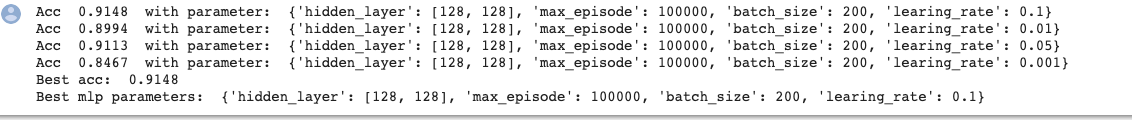

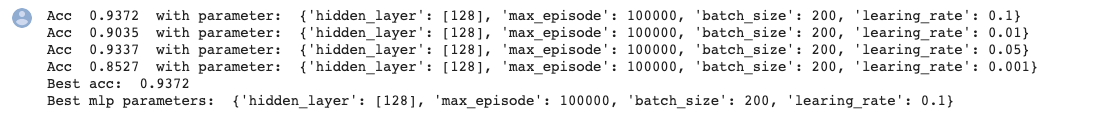

## Run Experiments

In [ ]:
def test(mlp):

   # yp = mlp.predict(x_test)
    #print("before train, on test set: ", mlp.evaluate(y_test, yp))
   # print("before train, on train set: ", mlp.evaluate(y_train, mlp.predict(x_train)))
   # print("start train")

    mlp.fit(x_train, y_train)
    yp = mlp.predict(x_test)
    print("after train, on test set:", mlp.evaluate(y_test, yp))
    print("after train, on train set:", mlp.evaluate(y_train, mlp.predict(x_train)))
    print()

2 layers 100 000 max_episodes

In [ ]:
test(MLP(hidden_layer=[], max_episode=10000, learing_rate=0.01))
#
test(MLP(hidden_layer=[128], max_episode=10000, learing_rate=0.01))
#
test(MLP(hidden_layer=[128, 128], max_episode=100000, learing_rate=0.1))

after train, on test set: 0.7737
after train, on train set: 0.7678666666666667

after train, on test set: 0.8605
after train, on train set: 0.8661333333333333

after train, on test set: 0.9038
after train, on train set: 0.9331666666666667



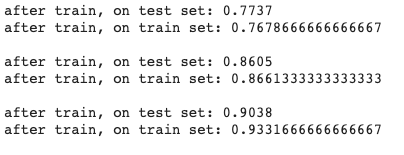

2 layers 1000 000 max_episodes

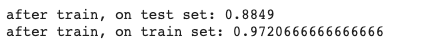

2 layers 500 000 max_episodes: 1h41min41s

In [ ]:
test(MLP(hidden_layer=[128, 128], max_episode=500000, learing_rate=0.1))

after train, on test set: 0.9429
after train, on train set: 0.9937666666666667



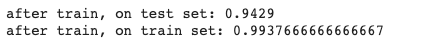

Sigmoid
On newly normalized data: 
after train, on test set: 0.9474
after train, on train set: 0.99125

In [ ]:
test(MLP(hidden_layer=[128, 128], max_episode=100000, learing_rate=0.1, active_func = sigmoid))

after train, on test set: 0.9474
after train, on train set: 0.99125



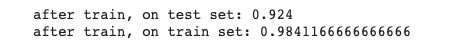

Tanh

In [ ]:
test(MLP(hidden_layer=[128, 128], max_episode=100000, learing_rate=0.1, active_func = tanh))

after train, on test set: 0.8497
after train, on train set: 0.99705



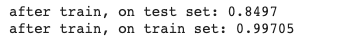

### Run on unormalized data

after train, on test set: 0.1135

after train, on train set: 0.11236666666666667

19m2s

In [ ]:
# unormalized data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

num_train, num_test = x_train.shape[0], x_test.shape[0]
x_train = x_train.reshape(num_train, -1)    # vectorization
x_test = x_test.reshape(num_test, -1)

In [ ]:
test(MLP(hidden_layer=[128, 128], max_episode=100000, learing_rate=0.1))

after train, on test set: 0.1135
after train, on train set: 0.11236666666666667



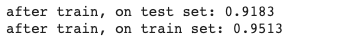

In [ ]:
test(MLP(hidden_layer=[128, 128], max_episode=100000, learing_rate=0.1, active_func = sigmoid))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


after train, on test set: 0.9413
after train, on train set: 0.9545166666666667



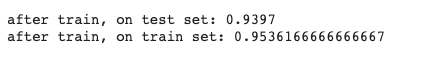

In [ ]:
test(MLP(hidden_layer=[128, 128], max_episode=100000, learing_rate=0.1, active_func = tanh))

after train, on test set: 0.89
after train, on train set: 0.8975166666666666

